# **Basic Neural Network**

### **Imports**

[*********************100%***********************]  1 of 1 completed


[[ 105.76000214]
 [ 105.22000122]
 [ 106.51999664]
 ...
 [5745.37011719]
 [5738.16992188]
 [5762.47998047]] (11281, 1)
(11281,) (11281,)


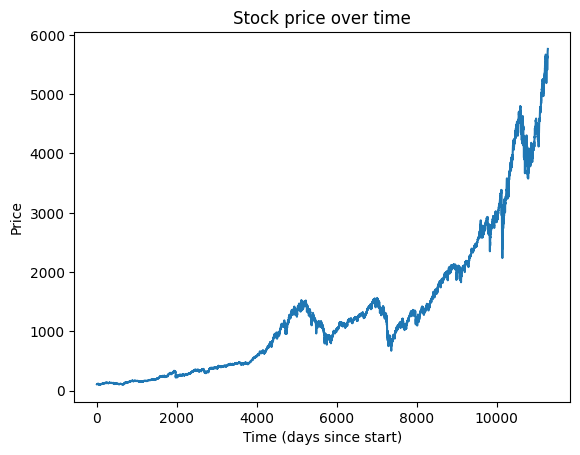

(10915, 365)
[105.76000214 105.22000122 106.51999664 106.80999756 108.94999695] (365,)
[105.22000122 106.51999664 106.80999756 108.94999695 109.05000305] (365,)
[106.51999664 106.80999756 108.94999695 109.05000305 109.88999939] (365,)
[106.80999756 108.94999695 109.05000305 109.88999939 109.91999817] (365,)
train_size: 8732
test_size: 2183
x_size: (8732, 365) (2183, 365)
y_size: (8732,) (2183,)


In [3]:
import yfinance as yf
import pandas as pd
from google.colab import files
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import random

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from datapreparation import get_stock, bin_data, split_data

### **Data Collection and Preparation**

In [14]:
# Define parameters
stock = ['^GSPC', '1980-01-01', '2024-10-01']

# Get the stock data, makes bins, and split the data
df, index = get_stock(stock[1], stock[2], stock[0])
bin_size = 365
bins = bin_data(df, bin_size)
X_train, y_train, X_test, y_test, train_index, test_index, train_size, test_size = split_data(bins, df, index, bin_size)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

[*********************100%***********************]  1 of 1 completed


In [5]:
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

### **Model Instantiation**

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Input to hidden layer
        self.fc2 = nn.Linear(hidden_size, output_size)  # Hidden to output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))  # Apply ReLU activation to hidden layer
        x = self.fc2(x)         # Output layer
        return x

In [7]:
input_size = X_train.shape[1]  # Example input size (features)
hidden_size = 16 # Number of neurons in hidden layer
output_size = 1  # Example output size (e.g., regression)

model = NeuralNetwork(input_size, hidden_size, output_size)

### **Model Training**

In [8]:
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
import time
def train_model(model, dataloader, epochs=1000):
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in dataloader:
            batch_y = batch_y.unsqueeze(1)
            optimizer.zero_grad()          # Zero the gradient buffers
            predictions = model(batch_X)  # Forward pass
            loss = criterion(predictions, batch_y)  # Compute loss
            loss.backward()                # Backward pass
            optimizer.step()               # Update parameters
            epoch_loss += loss.item()

        if (epoch+1) % 100 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Average Loss: {epoch_loss / len(dataloader) :.4f}")

time1 = time.time()
train_model(model, dataloader, epochs=1000)
time2 = time.time()
print(f"Training time: {time2-time1} seconds")

Epoch 100/1000, Average Loss: 336.9834
Epoch 200/1000, Average Loss: 290.2111
Epoch 300/1000, Average Loss: 335.3448
Epoch 400/1000, Average Loss: 361.2770
Epoch 500/1000, Average Loss: 316.5509
Epoch 600/1000, Average Loss: 302.5509
Epoch 700/1000, Average Loss: 312.8337
Epoch 800/1000, Average Loss: 279.1034
Epoch 900/1000, Average Loss: 304.5284
Epoch 1000/1000, Average Loss: 311.0934
Training time: 852.9546446800232 seconds


Test Predictions (first 5): tensor([[1924.4955],
        [1914.3059],
        [1916.3840],
        [1946.1798],
        [1957.4608]])
Test MSE Loss: 4144.1587


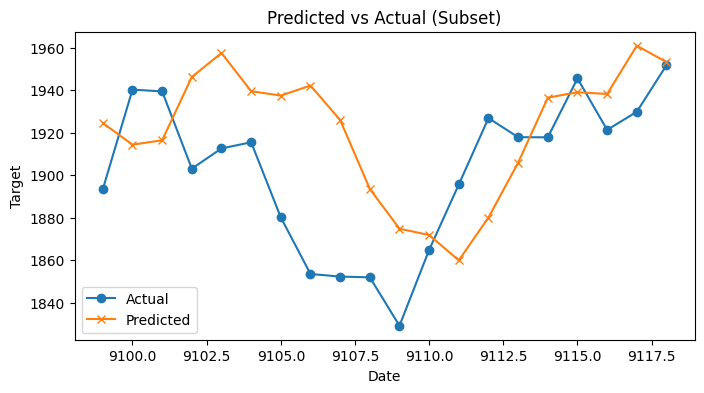

In [15]:
# Evaluate the model on test data
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)
    test_loss = torch.nn.functional.mse_loss(test_predictions, y_test).item()

# Print a few predictions and MSE loss
print("Test Predictions (first 5):", test_predictions[:5])
print(f"Test MSE Loss: {test_loss:.4f}")

# Convert tensors to NumPy for plotting
test_predictions = test_predictions.numpy().flatten()
y_test = y_test.numpy().flatten()

# Plot only a subset of the data (e.g., first 20 points)
subset_size = 20
plt.figure(figsize=(8, 4))
plt.plot(test_index[:subset_size], y_test[:subset_size], label='Actual', marker='o')
plt.plot(test_index[:subset_size], test_predictions[:subset_size], label='Predicted', marker='x')
plt.xlabel('Date')
plt.ylabel('Target')
plt.title('Predicted vs Actual (Subset)')
plt.legend()
plt.show()